In [1]:
# ======================================
# XGBoost + Landmark (for PFS-only & PFS+PRO)
# ======================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve, classification_report
from xgboost import XGBClassifier

RANDOM_SEED = 42
TEST_SIZE   = 0.20
VALID_SIZE  = 0.20
L = 365  # landmark days; can change to 90/180/365

In [2]:
# ---------------- 0) Read/select columns ----------------
df = pd.read_csv("Merged_PRO_TTFD_01OCT2025.csv")
target_col = "DTH"
pro_cols   = ["ARM", "EMPLOY", "LESION1", "ECOG", "HER2"]          # your PRO/baseline
pfs_cols_all = [c for c in df.columns if c.upper().startswith("PFS")]  # auto-detect PFS* (including PFSDY)
keep_cols = list(dict.fromkeys([target_col] + pro_cols + pfs_cols_all))
keep_cols = [c for c in keep_cols if c in df.columns]
d = df[keep_cols].copy()

# ---------------- 1) Clean labels ----------------
d[target_col] = pd.to_numeric(d[target_col], errors="coerce")
d.loc[d[target_col].isin([-999, -1, 999]), target_col] = np.nan
d = d[d[target_col].isin([0, 1])].copy()
d[target_col] = d[target_col].astype(int)


In [3]:
# ---------------- 2) Clean features (PFS/PFSDY) ----------------
for c in d.columns:
    if c == target_col:
        continue
    d.loc[d[c].isin([-999, "-999"]), c] = np.nan

if "PFS" in d.columns:
    d["PFS"] = pd.to_numeric(d["PFS"], errors="coerce")
    d.loc[~d["PFS"].isin([0, 1]), "PFS"] = np.nan

if "PFSDY" in d.columns:
    d["PFSDY"] = pd.to_numeric(d["PFSDY"], errors="coerce")
    d.loc[d["PFSDY"] <= 0, "PFSDY"] = np.nan

# String columns → string dtype, fill with "missing" (for one-hot)
for c in d.columns:
    if c == target_col: 
        continue
    if d[c].dtype == "O" or str(d[c].dtype).startswith("string"):
        d[c] = d[c].astype("string").fillna("missing")

In [4]:
print(d.shape)

(1337, 8)


In [5]:
# ---------------- 3) Landmark builder function ----------------
def build_landmark_view(df_in: pd.DataFrame, L: int,
                        baseline_cols, pfs_cols):
    """
    Returns: df_lmk (individuals still at risk at day L, with landmark features)
             feats_pfs_L (PFS-only features)
             feats_both_L (PFS+PRO features)
    Rules:
      - PFS_by_L : (PFSDY<=L) -> 1 else 0 (missing PFSDY treated as 0)
      - PFSDY_trunc : min(PFSDY, L); if no progression or missing -> set to L (represents "no progression up to L")
      - Sample filtering: if an OS time column is detected, keep only individuals with OS_time > L (strict landmark)
                          if no OS time column -> approximate landmark: only drop individuals with PFSDY<=L and DTH==1 and PFSDY not missing (conservative)
    """
    df = df_in.copy()

    # Detect OS time column
    cand = ["OSDY", "OS_DAY", "DEATHDY", "DeathDY", "OS_days"]
    OS_COL = next((c for c in cand if c in df.columns), None)

    # Build PFS@L features
    if "PFSDY" in df.columns:
        pf = df["PFSDY"]
        df["PFS_by_L"] = (pf.notna() & (pf <= L)).astype(int)
        df["PFSDY_trunc"] = np.where(pf.notna(), np.minimum(pf, L), L)
    else:
        # Without PFSDY, fall back to binary PFS (still usable for landmark, but coarser information)
        df["PFS_by_L"] = (df.get("PFS", pd.Series(index=df.index)) == 1).astype(int)
        df["PFSDY_trunc"] = L

    # Sample filtering (at risk at L)
    if OS_COL is not None:
        df[OS_COL] = pd.to_numeric(df[OS_COL], errors="coerce")
        before_n = len(df)
        df = df[df[OS_COL] > L].copy()
        print(f"[Landmark] Using OS time column `{OS_COL}`, keeping individuals alive at L={L} days: {before_n} -> {len(df)}")
    else:
        # Approximate filtering (if PFSDY<=L and DTH==1 and PFSDY not missing, likely event before L; drop)
        before_n = len(df)
        cond = (df.get("PFSDY").notna()) & (df["PFSDY"] <= L) & (df[target_col] == 1)
        df = df[~cond].copy()
        print(f"[Landmark-approx] No OS time column detected; applying conservative filtering: {before_n} -> {len(df)}")
        print("  Note: It is recommended to provide an OS time column (e.g., OSDY/DEATHDY) for a strict landmark.")

    # Assemble feature columns
    feats_pfs_L  = ["PFS_by_L", "PFSDY_trunc"]
    feats_both_L = list(dict.fromkeys(baseline_cols + feats_pfs_L))

    # One-hot encoding (only for string columns)
    def prepare_X(df, feature_cols):
        sub = df[feature_cols].copy()
        cat_cols = [c for c in feature_cols
                    if (sub[c].dtype == "O") or str(sub[c].dtype).startswith("string")]
        if cat_cols:
            sub = pd.get_dummies(sub, columns=cat_cols, drop_first=True)
        return sub

    X_pfs_L  = prepare_X(df, feats_pfs_L)
    X_both_L = prepare_X(df, feats_both_L)
    y_L      = df[target_col].values

    return df, X_pfs_L, X_both_L, y_L, feats_pfs_L, feats_both_L

In [6]:
# ---------------- 4) Non-landmark (PRO-only) design matrix ----------------
def prepare_X(df, feature_cols):
    sub = df[feature_cols].copy()
    cat_cols = [c for c in feature_cols
                if (sub[c].dtype == "O") or str(sub[c].dtype).startswith("string")]
    if cat_cols:
        sub = pd.get_dummies(sub, columns=cat_cols, drop_first=True)
    return sub

X_pro  = prepare_X(d, [c for c in pro_cols if c in d.columns])
y_all  = d[target_col].values

# ---------------- 5) Landmark view (for PFS-only / PFS+PRO) ----------------
d_L, X_pfs_L, X_both_L, y_L, feats_pfs_L, feats_both_L = build_landmark_view(
    d, L, baseline_cols=[c for c in pro_cols if c in d.columns], pfs_cols=pfs_cols_all
)

[Landmark-approx] No OS time column detected; applying conservative filtering: 1337 -> 1096
  Note: It is recommended to provide an OS time column (e.g., OSDY/DEATHDY) for a strict landmark.


In [7]:
# ---------------- 6) Training/evaluation utilities ----------------
def split_sets(X, y):
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=TEST_SIZE, stratify=y, random_state=RANDOM_SEED
    )
    X_tr, X_val, y_tr, y_val = train_test_split(
        X_train, y_train, test_size=VALID_SIZE, stratify=y_train, random_state=RANDOM_SEED
    )
    return X_tr, X_val, X_test, y_tr, y_val, y_test

def class_weight(y):
    pos = int((y == 1).sum()); neg = int((y == 0).sum())
    return neg / max(pos, 1)

common_params = dict(
    objective="binary:logistic",
    eval_metric="auc",
    learning_rate=0.05,
    max_depth=5,
    min_child_weight=3,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_lambda=2.0,
    reg_alpha=0.0,
    n_estimators=5000,        # generous upper limit; controlled via early stopping
    tree_method="hist",       # switch to "gpu_hist" if you have a GPU
    random_state=RANDOM_SEED
)


In [8]:
def fit_eval(X, y, name):
    X_tr, X_val, X_te, y_tr, y_val, y_te = split_sets(X, y)

    print(f"Total number: {len(X_tr)+len(X_te)+len(X_val):,}")
    
    params = common_params.copy()
    params["scale_pos_weight"] = class_weight(y_tr)

    mdl = XGBClassifier(**params)
    mdl.fit(
        X_tr, y_tr,
        eval_set=[(X_val, y_val)],
        # early_stopping_rounds=100,
        verbose=False
    )
    prob = mdl.predict_proba(X_te)[:, 1]
    auc  = roc_auc_score(y_te, prob)
    fpr, tpr, _ = roc_curve(y_te, prob)
    y_pred = (prob >= 0.5).astype(int)
    print(f"\nClassification Report ({name}, thr=0.50):\n",
          classification_report(y_te, y_pred, digits=3))
    print(f"{name} AUC: {auc:.3f}")
    return auc, fpr, tpr, mdl

In [9]:
# ---------------- 7) 3 training models ----------------
# 7.1 PRO-only（no landmark）
auc_pro,  fpr_pro,  tpr_pro,  mdl_pro  = fit_eval(X_pro, y_all,   name="PRO only")

# 7.2 PFS-only（Landmark）
auc_pfs,  fpr_pfs,  tpr_pfs,  mdl_pfs  = fit_eval(X_pfs_L, y_L,   name=f"PFS-only @L={L}")

# 7.3 PFS+PRO（Landmark）
auc_both, fpr_both, tpr_both, mdl_both = fit_eval(X_both_L, y_L,  name=f"PRO+PFS @L={L}")

print(f"\nAUCs -> PRO only: {auc_pro:.3f} | PFS-only@L: {auc_pfs:.3f} | PRO+PFS@L: {auc_both:.3f}")


Total number: 1,337

Classification Report (PRO only, thr=0.50):
               precision    recall  f1-score   support

           0      0.690     0.806     0.743       124
           1      0.805     0.688     0.742       144

    accuracy                          0.743       268
   macro avg      0.747     0.747     0.743       268
weighted avg      0.752     0.743     0.742       268

PRO only AUC: 0.838
Total number: 1,096

Classification Report (PFS-only @L=365, thr=0.50):
               precision    recall  f1-score   support

           0      1.000     0.218     0.358       124
           1      0.497     1.000     0.664        96

    accuracy                          0.559       220
   macro avg      0.749     0.609     0.511       220
weighted avg      0.781     0.559     0.491       220

PFS-only @L=365 AUC: 0.609
Total number: 1,096

Classification Report (PRO+PFS @L=365, thr=0.50):
               precision    recall  f1-score   support

           0      0.803     0.919

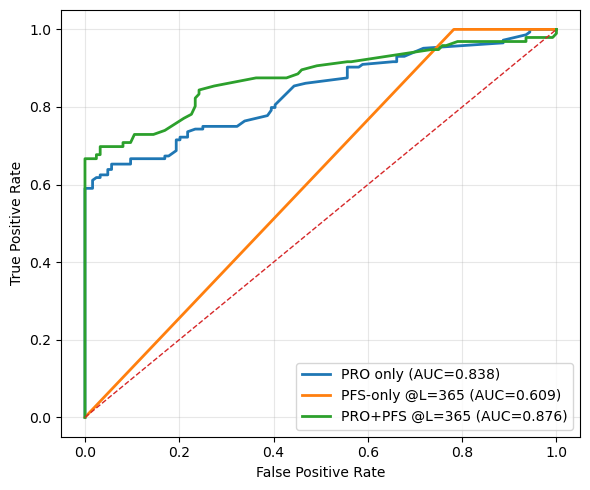

In [10]:
# ---------------- 8) ROC-AUC plot ----------------
plt.figure(figsize=(6,5))
plt.plot(fpr_pro,  tpr_pro,  lw=2, label=f"PRO only (AUC={auc_pro:.3f})")
plt.plot(fpr_pfs,  tpr_pfs,  lw=2, label=f"PFS-only @L={L} (AUC={auc_pfs:.3f})")
plt.plot(fpr_both, tpr_both, lw=2, label=f"PRO+PFS @L={L} (AUC={auc_both:.3f})")
plt.plot([0,1], [0,1], "--", lw=1)
plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
plt.legend(loc="lower right"); plt.grid(alpha=0.3); plt.tight_layout(); plt.show()

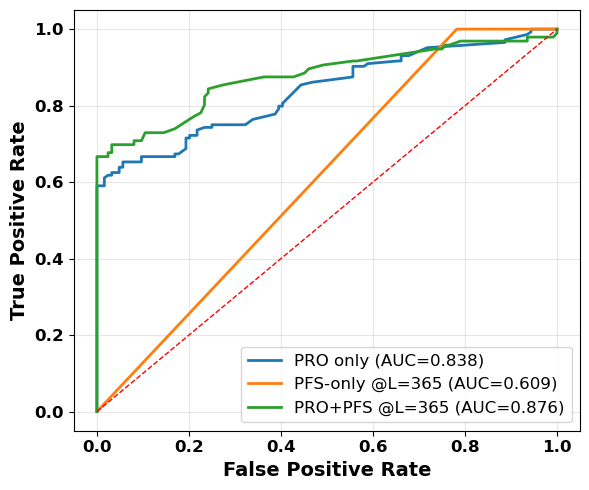

In [11]:
# ---------------- 8) ROC-AUC plot ----------------
plt.figure(figsize=(6,5))

plt.plot(fpr_pro,  tpr_pro,  lw=2, label=f"PRO only (AUC={auc_pro:.3f})")
plt.plot(fpr_pfs,  tpr_pfs,  lw=2, label=f"PFS-only @L={L} (AUC={auc_pfs:.3f})")
plt.plot(fpr_both, tpr_both, lw=2, label=f"PRO+PFS @L={L} (AUC={auc_both:.3f})")
plt.plot([0,1], [0,1], "--", lw=1, color="red")

plt.xlabel("False Positive Rate", fontsize=14, fontweight="bold")
plt.ylabel("True Positive Rate", fontsize=14, fontweight="bold")
#plt.title("ROC Curves Comparison", fontsize=16, fontweight="bold")

# 放大并加粗刻度数字
plt.xticks(fontsize=12, fontweight="bold")
plt.yticks(fontsize=12, fontweight="bold")

# Legend 样式
plt.legend(loc="lower right", fontsize=12, frameon=True)

plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig("roc_curves_landmark.tiff", dpi=300, bbox_inches="tight", format="tiff")
plt.show()